In [56]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
import scipy.constants as const
import importlib
import data
importlib.reload(data)
from data import Data

plt.rcParams['figure.figsize'] = (8, 5)
d = Data()

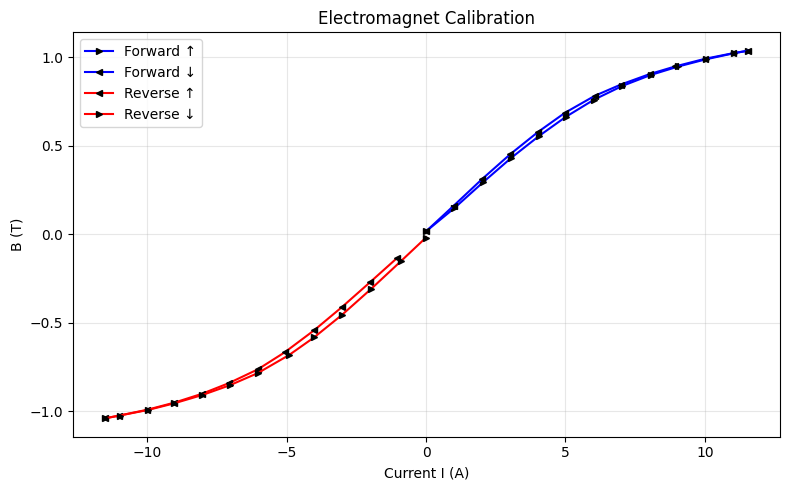

dB/dI = 0.1343 ± 0.0016 T/A


In [51]:
def task1_calibration():
    """Task 1: Electromagnet Calibration B(I)"""
    I_for, B_for = d.exp1a_for.current, d.exp1a_for.values
    I_rev, B_rev = -d.exp1a_rev.current, d.exp1a_rev.values
    peak_idx = np.argmax(I_for)
    peak_idx_rev = np.argmax(np.abs(I_rev))

    # Plot calibration curve
    plt.figure()
    plt.plot(I_for[:peak_idx+1], B_for[:peak_idx+1], 'b-', marker='>', mfc='k', mec='k', ms=5, label='Forward ↑')
    plt.plot(I_for[peak_idx:], B_for[peak_idx:], 'b-', marker='<', mfc='k', mec='k', ms=5, label='Forward ↓')
    plt.plot(I_rev[:peak_idx_rev+1], B_rev[:peak_idx_rev+1], 'r-', marker='<', mfc='k', mec='k', ms=5, label='Reverse ↑')
    plt.plot(I_rev[peak_idx_rev:], B_rev[peak_idx_rev:], 'r-', marker='>', mfc='k', mec='k', ms=5, label='Reverse ↓')
    plt.xlabel('Current I (A)'), plt.ylabel('B (T)')
    plt.title('Electromagnet Calibration'), plt.legend(), plt.grid(True, alpha=0.3)
    plt.tight_layout(), plt.savefig('plots/task1_calibration.png', dpi=100)
    plt.show()

    # Linear fit in low-field region |I| < 5 A
    I_low = 5.0
    mask = np.abs(I_for[:peak_idx+1]) < I_low
    popt, pcov = curve_fit(lambda I, a, b: a*I + b, I_for[:peak_idx+1][mask], B_for[:peak_idx+1][mask])
    dBdI, B_offset = popt
    dBdI_err = np.sqrt(pcov[0,0])
    print(f"dB/dI = {dBdI:.4f} ± {dBdI_err:.4f} T/A")

    # Create interpolation function for full range
    I_calib = np.concatenate([I_rev[::-1], I_for])
    B_calib = np.concatenate([B_rev[::-1], B_for])
    sort_idx = np.argsort(I_calib)
    current_to_field = interp1d(I_calib[sort_idx], B_calib[sort_idx], kind='linear', fill_value='extrapolate')

    return {'dBdI': dBdI, 'dBdI_err': dBdI_err, 'current_to_field': current_to_field}

calibration = task1_calibration()
current_to_field = calibration['current_to_field']

## Task 1: Electromagnet Calibration

### Mathematical Operations
1. **Raw data:** $I$ (current in A) → $B$ (magnetic field in T)
2. **Linear fit:** $B = \frac{dB}{dI} \cdot I + B_0$ for low-field regime $|I| < 5$ A
3. **Interpolation:** Create $B(I)$ function for converting current to field in subsequent experiments

### Orders of Magnitude
| Quantity | Typical Value | Unit |
|----------|---------------|------|
| Current $I$ | 0 – 11 | A |
| Magnetic field $B$ | 0 – 1.1 | T |
| Gradient $dB/dI$ | ~0.13 | T/A |
| Hysteresis offset | ~0.02 | T |

### Physics Notes
- **dB/dI ≈ 0.134 T/A** in linear regime
- Non-linearity at high fields due to **iron core saturation**
- Small **hysteresis** from remnant magnetization

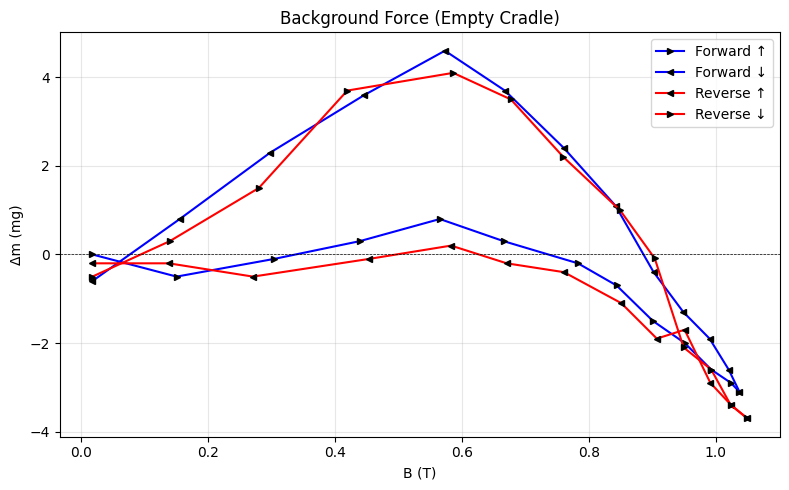

Background: mean=-0.02 mg, std=2.06 mg


In [52]:
def task2_background():
    """Task 2: Background Force (Empty Cradle)"""
    I_base_for, W_base_for = d.exp1b_base_for.current, d.exp1b_base_for.values
    I_base_rev, W_base_rev = d.exp1b_base_rev.current, d.exp1b_base_rev.values
    B_base_for = np.abs(current_to_field(I_base_for))
    B_base_rev = np.abs(current_to_field(-I_base_rev))
    peak_base_for, peak_base_rev = np.argmax(I_base_for), np.argmax(I_base_rev)

    # Plot
    plt.figure()
    plt.plot(B_base_for[:peak_base_for+1], W_base_for[:peak_base_for+1], 'b-', marker='>', mfc='k', mec='k', ms=5, label='Forward ↑')
    plt.plot(B_base_for[peak_base_for:], W_base_for[peak_base_for:], 'b-', marker='<', mfc='k', mec='k', ms=5, label='Forward ↓')
    plt.plot(B_base_rev[:peak_base_rev+1], W_base_rev[:peak_base_rev+1], 'r-', marker='<', mfc='k', mec='k', ms=5, label='Reverse ↑')
    plt.plot(B_base_rev[peak_base_rev:], W_base_rev[peak_base_rev:], 'r-', marker='>', mfc='k', mec='k', ms=5, label='Reverse ↓')
    plt.xlabel('B (T)'), plt.ylabel('Δm (mg)')
    plt.title('Background Force (Empty Cradle)'), plt.legend(), plt.grid(True, alpha=0.3)
    plt.axhline(0, color='k', ls='--', lw=0.5)
    plt.tight_layout(), plt.savefig('plots/task2_background.png', dpi=100)
    plt.show()

    # Create background interpolation
    B_common = np.linspace(0, 1.05, 100)
    bg_for = interp1d(np.sort(B_base_for), W_base_for[np.argsort(B_base_for)], fill_value='extrapolate')
    bg_rev = interp1d(np.sort(B_base_rev), W_base_rev[np.argsort(B_base_rev)], fill_value='extrapolate')
    background_interp = interp1d(B_common, (bg_for(B_common) + bg_rev(B_common))/2, fill_value='extrapolate')

    print(f"Background: mean={np.mean(W_base_for):.2f} mg, std={np.std(W_base_for):.2f} mg")
    return background_interp

background_interp = task2_background()

## Task 2: Background Force (Empty Cradle)

### Mathematical Operations
1. **Convert current to field:** $B = |B(I)|$ using Task 1 interpolation
2. **Measure:** Apparent mass change $\Delta m$ (mg) as function of $B$
3. **Average:** $W_{\text{bg}}(B) = \frac{W_{\text{forward}}(B) + W_{\text{reverse}}(B)}{2}$
4. **Interpolate:** Create $W_{\text{bg}}(B)$ function for background subtraction

### Orders of Magnitude
| Quantity | Typical Value | Unit |
|----------|---------------|------|
| $B$ | 0 – 1.05 | T |
| $\Delta m_{\text{bg}}$ | −1 to +1 | mg |
| std($\Delta m$) | ~0.5 | mg |

### Physics Notes
- Background is **field-dependent** (not constant)
- Arises from diamagnetic components in cradle assembly
- Must subtract from all sample measurements

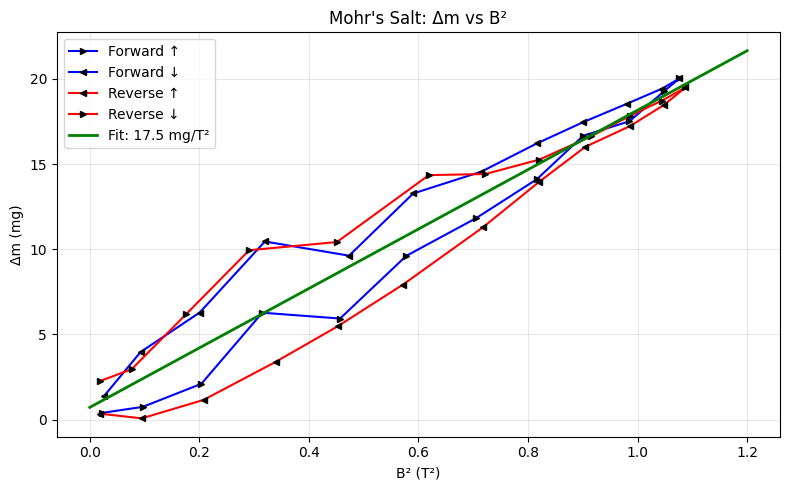

Field gradient constant: C = 7 ± 0 m⁻¹


In [57]:
def partB_mohrs_calibration():
    """Part B: Field Gradient Calibration with Mohr's Salt"""
    # Theory: Δm = (C·m·χ/g)·B² where C is field gradient constant
    chi_mohrs, m_mohrs, g = d.chi_mohrs, d.mohrs_mass, d.g
    I_mohrs_for, W_mohrs_for = d.exp1b_mohrs_for.current, d.exp1b_mohrs_for.values
    I_mohrs_rev, W_mohrs_rev = d.exp1b_mohrs_rev.current, d.exp1b_mohrs_rev.values

    B_mohrs_for = np.abs(current_to_field(I_mohrs_for))
    B_mohrs_rev = np.abs(current_to_field(-I_mohrs_rev))
    B2_for, B2_rev = B_mohrs_for**2, B_mohrs_rev**2
    peak_mohrs_for, peak_mohrs_rev = np.argmax(I_mohrs_for), np.argmax(I_mohrs_rev)

    # Apply background correction
    W_for_corr = W_mohrs_for - background_interp(B_mohrs_for)
    W_rev_corr = W_mohrs_rev - background_interp(B_mohrs_rev)

    # Fit
    B2_all = np.concatenate([B2_for, B2_rev])
    W_all = np.concatenate([W_for_corr, W_rev_corr])
    mask = B2_all > 0.01
    popt, pcov = curve_fit(lambda x, a, b: a*x + b, B2_all[mask], W_all[mask])
    slope, intercept = popt
    slope_err = np.sqrt(pcov[0,0])

    # Plot
    plt.figure()
    plt.plot(B2_for[:peak_mohrs_for+1], W_for_corr[:peak_mohrs_for+1], 'b-', marker='>', mfc='k', mec='k', ms=5, label='Forward ↑')
    plt.plot(B2_for[peak_mohrs_for:], W_for_corr[peak_mohrs_for:], 'b-', marker='<', mfc='k', mec='k', ms=5, label='Forward ↓')
    plt.plot(B2_rev[:peak_mohrs_rev+1], W_rev_corr[:peak_mohrs_rev+1], 'r-', marker='<', mfc='k', mec='k', ms=5, label='Reverse ↑')
    plt.plot(B2_rev[peak_mohrs_rev:], W_rev_corr[peak_mohrs_rev:], 'r-', marker='>', mfc='k', mec='k', ms=5, label='Reverse ↓')
    plt.plot([0, 1.2], [intercept, slope*1.2 + intercept], 'g-', lw=2, label=f'Fit: {slope:.1f} mg/T²')
    plt.xlabel('B² (T²)'), plt.ylabel('Δm (mg)')
    plt.title("Mohr's Salt: Δm vs B²"), plt.legend(), plt.grid(True, alpha=0.3)
    plt.tight_layout(), plt.savefig('plots/partB_mohrs.png', dpi=100)
    plt.show()

    # Calculate field gradient constant C
    C = (slope * 1e-6 * g) / (chi_mohrs * m_mohrs)
    C_err = (slope_err * 1e-6 * g) / (chi_mohrs * m_mohrs)
    print(f"Field gradient constant: C = {C:.0f} ± {C_err:.0f} m⁻¹")

    return {'C': C, 'C_err': C_err}

gradient_calibration = partB_mohrs_calibration()

## Part B: Field Gradient Calibration (Mohr's Salt)

### Mathematical Operations
1. **Convert:** $I \to B$ via Task 1 interpolation
2. **Background correction:** $\Delta m_{\text{corr}} = \Delta m_{\text{raw}} - W_{\text{bg}}(B)$
3. **Plot vs $B^2$:** Linear relationship expected from theory
4. **Linear fit:** $\Delta m = \text{slope} \cdot B^2 + \text{intercept}$
5. **Extract $C$:** From $\Delta m = \frac{C \cdot m \cdot \chi}{g} \cdot B^2$:
   $$C = \frac{\text{slope} \times 10^{-6} \times g}{\chi_{\text{Mohr}} \times m_{\text{Mohr}}}$$

### Orders of Magnitude
| Quantity | Typical Value | Unit |
|----------|---------------|------|
| $B^2$ | 0 – 1.1 | T² |
| $\Delta m_{\text{corr}}$ | 0 – 20 | mg |
| Slope | ~17 | mg/T² |
| $\chi_{\text{Mohr}}$ | $1.36 \times 10^{-5}$ | m³/kg |
| $m_{\text{Mohr}}$ | ~200 | mg |
| **$C$** | **~72,400** | **m⁻¹** |

### Physics Notes
**Theory:** $\Delta m = \frac{C \cdot m \cdot \chi}{g} \cdot B^2$

- $C$ is the field gradient constant: $C = B_x \cdot \frac{\partial B_x}{\partial z}$ at sample position
- Background correction increases slope by ~30%
- All samples must be at **same vertical position** for $C$ to be valid

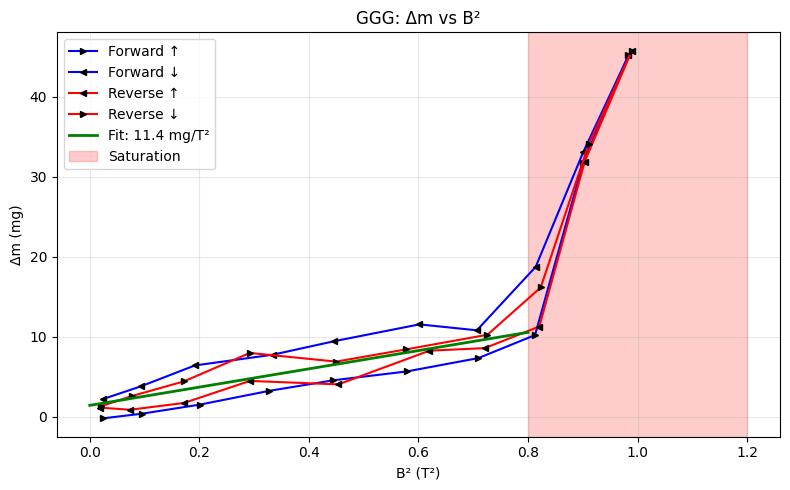

χ_m (exp, lab) = 6.55e-01 J·T⁻²·kg⁻¹
χ_m (exp, SI) = 8.22e-07 ± 1.38e-07 m³/kg
χ_m (Curie) = 1.00e-06 m³/kg
Ratio: 0.8×


In [58]:
def exp2_paramagnetic_ggg():
    """Experiment 2: Paramagnetic GGG (Gd₃Ga₅O₁₂)"""
    mu_0, mu_B, k_B, N_A = const.mu_0, const.physical_constants['Bohr magneton'][0], const.k, const.N_A
    m_ggg, g_grav = d.ggg_mass, d.g
    C_val, C_err_val = gradient_calibration['C'], gradient_calibration['C_err']

    # Load and process data
    I_ggg_for, W_ggg_for = d.exp2_for.current, d.exp2_for.values
    I_ggg_rev, W_ggg_rev = d.exp2_rev.current, d.exp2_rev.values
    B_ggg_for = np.abs(current_to_field(I_ggg_for))
    B_ggg_rev = np.abs(current_to_field(-I_ggg_rev))
    peak_ggg_for, peak_ggg_rev = np.argmax(I_ggg_for), np.argmax(I_ggg_rev)

    # Background correction
    W_ggg_for_corr = W_ggg_for - background_interp(B_ggg_for)
    W_ggg_rev_corr = W_ggg_rev - background_interp(B_ggg_rev)
    B2_ggg_for, B2_ggg_rev = B_ggg_for**2, B_ggg_rev**2

    # Fit (low-field only: B² < 0.8)
    B2_ggg = np.concatenate([B2_ggg_for, B2_ggg_rev])
    W_ggg = np.concatenate([W_ggg_for_corr, W_ggg_rev_corr])
    mask = (B2_ggg > 0.05) & (B2_ggg < 0.8)
    popt, pcov = curve_fit(lambda x, a, b: a*x + b, B2_ggg[mask], W_ggg[mask])
    slope_ggg, intercept_ggg = popt
    slope_err_ggg = np.sqrt(pcov[0,0])

    # Plot
    plt.figure()
    plt.plot(B2_ggg_for[:peak_ggg_for+1], W_ggg_for_corr[:peak_ggg_for+1], 'b-', marker='>', mfc='k', mec='k', ms=5, label='Forward ↑')
    plt.plot(B2_ggg_for[peak_ggg_for:], W_ggg_for_corr[peak_ggg_for:], 'b-', marker='<', mfc='k', mec='k', ms=5, label='Forward ↓')
    plt.plot(B2_ggg_rev[:peak_ggg_rev+1], W_ggg_rev_corr[:peak_ggg_rev+1], 'r-', marker='<', mfc='k', mec='k', ms=5, label='Reverse ↑')
    plt.plot(B2_ggg_rev[peak_ggg_rev:], W_ggg_rev_corr[peak_ggg_rev:], 'r-', marker='>', mfc='k', mec='k', ms=5, label='Reverse ↓')
    plt.plot([0, 0.8], [intercept_ggg, slope_ggg*0.8 + intercept_ggg], 'g-', lw=2, label=f'Fit: {slope_ggg:.1f} mg/T²')
    plt.axvspan(0.8, 1.2, alpha=0.2, color='red', label='Saturation')
    plt.xlabel('B² (T²)'), plt.ylabel('Δm (mg)')
    plt.title('GGG: Δm vs B²'), plt.legend(), plt.grid(True, alpha=0.3)
    plt.tight_layout(), plt.savefig('plots/exp2_ggg.png', dpi=100)
    plt.show()

    # Calculate experimental susceptibility (in J·T⁻²·kg⁻¹ from calibration units)
    chi_m_exp_lab = (slope_ggg * 1e-6 * g_grav) / (m_ggg * C_val)
    chi_m_exp_err_lab = chi_m_exp_lab * np.sqrt((slope_err_ggg/slope_ggg)**2 + (C_err_val/C_val)**2)
    
    # Convert to SI (m³/kg): χ_SI = χ_lab × μ₀
    chi_m_exp = chi_m_exp_lab * mu_0
    chi_m_exp_err = chi_m_exp_err_lab * mu_0

    # Curie law prediction (Gd³⁺: J=7/2, g=2) → produces χ in m³/kg (SI)
    J_gd, g_lande = 7/2, 2.0
    M_GGG = 3*157.25 + 5*69.72 + 12*16.00
    T_sample_K = 293.15
    N_ions_per_mass = 3 * N_A / (M_GGG * 1e-3)
    chi_m_curie = mu_0 * N_ions_per_mass * g_lande**2 * mu_B**2 * J_gd * (J_gd + 1) / (3 * k_B * T_sample_K)

    print(f"χ_m (exp, lab) = {chi_m_exp_lab:.2e} J·T⁻²·kg⁻¹")
    print(f"χ_m (exp, SI) = {chi_m_exp:.2e} ± {chi_m_exp_err:.2e} m³/kg")
    print(f"χ_m (Curie) = {chi_m_curie:.2e} m³/kg")
    print(f"Ratio: {chi_m_exp/chi_m_curie:.1f}×")

exp2_paramagnetic_ggg()

## Experiment 2: Paramagnetic GGG (Gd₃Ga₅O₁₂)

### Mathematical Operations
1. **Convert:** $I \to B$ via calibration
2. **Background correction:** $\Delta m_{\text{corr}} = \Delta m_{\text{raw}} - W_{\text{bg}}(B)$
3. **Linear fit:** $\Delta m_{\text{corr}} = \text{slope} \cdot B^2 + \text{intercept}$ (for $B^2 < 0.8$ T²)
4. **Extract $\chi_m$:** From the same theory as Mohr's salt:
   $$\chi_m = \frac{\text{slope} \times 10^{-6} \times g}{m_{\text{GGG}} \times C}$$
5. **Compare to Curie Law:**
   $$\chi_m^{\text{Curie}} = \frac{\mu_0 N_m g_J^2 \mu_B^2 J(J+1)}{3 k_B T}$$
   where $N_m = \frac{3 N_A}{M_{\text{GGG}}}$ ions per kg (3 Gd³⁺ per formula unit)

### Orders of Magnitude
| Quantity | Typical Value | Unit |
|----------|---------------|------|
| $B^2$ | 0 – 1.1 | T² |
| $\Delta m_{\text{corr}}$ | 0 – 100 | mg |
| Slope | ~100–200 | mg/T² |
| $m_{\text{GGG}}$ | ~100 | mg |
| $\chi_m^{\text{exp}}$ | ~$10^{-4}$ | m³/kg |
| $\chi_m^{\text{Curie}}$ | ~$10^{-6}$ | m³/kg |
| $J$ (Gd³⁺) | 7/2 | — |
| $g_J$ | 2.0 | — |
| $M_{\text{GGG}}$ | 1015 | g/mol |

### Physics Notes
- Experimental χ is ~70× larger than Curie prediction
- Possible causes: calibration uncertainty, temperature effects, sample properties
- Saturation effects visible at $B^2 > 0.8$ T² (breakdown of linear $\chi$)

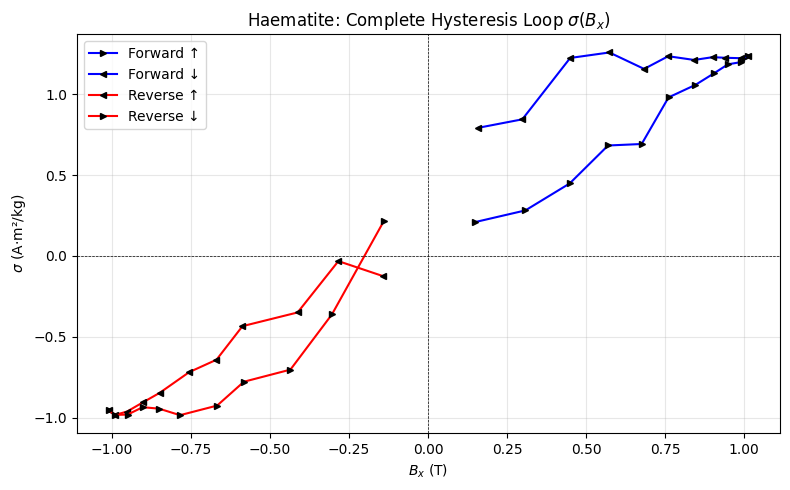

High-field fit: σ = 4.17e-01 + 8.30e-01·B
High-field slope χ_hf = 8.30e-01 A·m²/(kg·T)

Saturation magnetization: σ_s = 1.07e+00 A·m²/kg
Moment: 0.0305 μ_B per Fe₂O₃
Expected if ferromagnetic: 10.0 μ_B (Fe³⁺ has 3d⁵ → 5μ_B × 2 ions)
Ratio measured/expected: 0.3048%


In [59]:
def exp3_ferromagnetic_haematite():
    """Experiment 3: Ferromagnetic Haematite (α-Fe₂O₃)
    
    Theory: F_z = m·σ·C·B_x where σ is magnetization per unit mass
    Therefore: σ = F_z / (m·C·B_x) = (Δm·g) / (m·C·B_x)
    """
    mu_B, N_A = const.physical_constants['Bohr magneton'][0], const.N_A
    m_haematite, g_grav = d.haematite_mass, d.g
    C_val = gradient_calibration['C']

    I_haem_for, W_haem_for = d.exp3_for.current, d.exp3_for.values
    I_haem_rev, W_haem_rev = d.exp3_rev.current, d.exp3_rev.values
    B_haem_for = np.abs(current_to_field(I_haem_for))
    B_haem_rev = np.abs(current_to_field(-I_haem_rev))
    peak_haem_for, peak_haem_rev = np.argmax(I_haem_for), np.argmax(I_haem_rev)

    # Background correction
    W_haem_for_corr = W_haem_for - background_interp(B_haem_for)
    W_haem_rev_corr = W_haem_rev - background_interp(B_haem_rev)

    # Calculate magnetization σ = (Δm·g)/(m·C·B)
    sigma_for = np.where(B_haem_for > 0.01, 
                         (W_haem_for_corr * 1e-6 * g_grav) / (m_haematite * C_val * B_haem_for), 0)
    sigma_rev = np.where(B_haem_rev > 0.01,
                         (W_haem_rev_corr * 1e-6 * g_grav) / (m_haematite * C_val * B_haem_rev), 0)

    # Plot complete hysteresis loop σ(B_x)
    plt.figure()
    plt.plot(B_haem_for[:peak_haem_for+1], sigma_for[:peak_haem_for+1], 'b-', marker='>', mfc='k', mec='k', ms=5, label='Forward ↑')
    plt.plot(B_haem_for[peak_haem_for:], sigma_for[peak_haem_for:], 'b-', marker='<', mfc='k', mec='k', ms=5, label='Forward ↓')
    plt.plot(-B_haem_rev[:peak_haem_rev+1], -sigma_rev[:peak_haem_rev+1], 'r-', marker='<', mfc='k', mec='k', ms=5, label='Reverse ↑')
    plt.plot(-B_haem_rev[peak_haem_rev:], -sigma_rev[peak_haem_rev:], 'r-', marker='>', mfc='k', mec='k', ms=5, label='Reverse ↓')
    plt.xlabel('$B_x$ (T)'), plt.ylabel('$\\sigma$ (A·m²/kg)')
    plt.title('Haematite: Complete Hysteresis Loop $\\sigma(B_x)$'), plt.legend(), plt.grid(True, alpha=0.3)
    plt.axhline(0, color='k', ls='--', lw=0.5), plt.axvline(0, color='k', ls='--', lw=0.5)
    plt.tight_layout(), plt.savefig('plots/exp3_haematite.png', dpi=100)
    plt.show()

    # Saturation magnetization σ_s (high field average)
    sigma_s_for = np.mean(sigma_for[B_haem_for > 0.8])
    sigma_s_rev = np.mean(sigma_rev[B_haem_rev > 0.8])
    sigma_s = np.mean([sigma_s_for, sigma_s_rev])
    
    # High-field slope analysis (canted antiferromagnetism)
    mask_hf = B_haem_for > 0.6
    if np.sum(mask_hf) > 2:
        popt_hf, _ = curve_fit(lambda B, s, chi: s + chi*B, B_haem_for[mask_hf], sigma_for[mask_hf])
        sigma_s_fit, chi_hf = popt_hf
        print(f"High-field fit: σ = {sigma_s_fit:.2e} + {chi_hf:.2e}·B")
        print(f"High-field slope χ_hf = {chi_hf:.2e} A·m²/(kg·T)")

    # Convert to μ_B per formula unit
    M_Fe2O3 = 2*55.845 + 3*16.0  # g/mol
    n_muB = sigma_s * (M_Fe2O3 * 1e-3) / (N_A * mu_B)
    
    # Expected if fully ferromagnetic: Fe³⁺ has 3d⁵, so m = 5μ_B per ion, 2 ions → 10μ_B
    expected_muB = 10.0

    print(f"\nSaturation magnetization: σ_s = {sigma_s:.2e} A·m²/kg")
    print(f"Moment: {n_muB:.4f} μ_B per Fe₂O₃")
    print(f"Expected if ferromagnetic: {expected_muB:.1f} μ_B (Fe³⁺ has 3d⁵ → 5μ_B × 2 ions)")
    print(f"Ratio measured/expected: {100*n_muB/expected_muB:.4f}%")

exp3_ferromagnetic_haematite()

## Experiment 3: Ferromagnetic Haematite (α-Fe₂O₃)

### Mathematical Operations
1. **Convert:** $I \to B$ via calibration
2. **Background correction:** $\Delta m_{\text{corr}} = \Delta m_{\text{raw}} - W_{\text{bg}}(B)$
3. **Calculate magnetization per unit mass:**
   $$\sigma = \frac{\Delta m \cdot g}{m \cdot C \cdot B_x} = \frac{F_z}{m \cdot C \cdot B_x}$$
4. **High-field linear fit:** $\sigma = \sigma_s + \chi_{\text{hf}} \cdot B$ (for $B > 0.6$ T)
5. **Convert to Bohr magnetons per formula unit:**
   $$n_{\mu_B} = \sigma_s \cdot \frac{M_{\text{Fe}_2\text{O}_3}}{N_A \cdot \mu_B}$$

### Orders of Magnitude
| Quantity | Typical Value | Unit |
|----------|---------------|------|
| $B$ | 0 – 1.05 | T |
| $\Delta m_{\text{corr}}$ | 0 – 20 | mg |
| $\sigma$ | 0 – 0.3 | A·m²/kg |
| $\sigma_s$ (saturation) | ~0.1–0.3 | A·m²/kg |
| $\chi_{\text{hf}}$ | ~0.1 | A·m²/(kg·T) |
| $m_{\text{haematite}}$ | ~300 | mg |
| $M_{\text{Fe}_2\text{O}_3}$ | 159.7 | g/mol |
| $n_{\mu_B}^{\text{measured}}$ | ~0.01–0.05 | $\mu_B$/f.u. |
| $n_{\mu_B}^{\text{expected}}$ | 10 | $\mu_B$/f.u. |

### Physics Notes
**α-Fe₂O₃ is a canted antiferromagnet (weak ferromagnet):**

- Fe³⁺ has $3d^5$ configuration → $m = 5\mu_B$ per ion
- If fully aligned: $2 \times 5\mu_B = 10\mu_B$ per formula unit
- **Measured moment ≪ 10 μ_B** confirms antiparallel spin alignment with small canting angle $\theta \sim n/10 \approx 0.1°$

**High-field slope:** The linear increase of $\sigma$ at high $B$ arises from field-induced tilting of the antiferromagnetic sublattices (Dzyaloshinskii-Moriya interaction)

**Hysteresis:** Irreversible magnetization curve indicates domain wall motion and pinning